# Solving a Toy Version of the Chinese Postman Problem

This implementation uses the networkX library

See article [here](https://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/)

### Part 1: Reading Data and Creating Graph

In [116]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import itertools

Read the edges and nodes

In [117]:
edgelist = pd.read_csv("edgelist.csv")
nodelist = pd.read_csv("nodelist.csv")

Create graph

In [118]:
G = nx.Graph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges[0],edges[1],**edges[2:].to_dict())

for i,nodes in nodelist.iterrows():
    nx.set_node_attributes(G, {nodes['id']:  nodes[1:].to_dict()})  


C:\Users\Sneez\AppData\Local\Temp\ipykernel_38412\3596389911.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(edges[0],edges[1],**edges[2:].to_dict())


Take a step back and visualize the data in our graph

In [119]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

# of edges: 8
# of nodes: 5
[('depot', 'school', {'distance': 1.0, 'color': 'black', 'original': True}), ('depot', 'rink', {'distance': 1.41, 'color': 'black', 'original': True}), ('depot', 'hospital', {'distance': 1.0, 'color': 'black', 'original': True}), ('school', 'rink', {'distance': 1.0, 'color': 'black', 'original': True}), ('school', 'library', {'distance': 2.0, 'color': 'blue', 'original': True}), ('rink', 'hospital', {'distance': 1.0, 'color': 'black', 'original': True}), ('rink', 'library', {'distance': 1.0, 'color': 'black', 'original': True}), ('hospital', 'library', {'distance': 1.41, 'color': 'black', 'original': True})]
[('depot', {'x': 0, 'y': 0}), ('school', {'x': 1, 'y': 0}), ('rink', {'x': 1, 'y': 1}), ('hospital', {'x': 0, 'y': 1}), ('library', {'x': 1, 'y': 2})]


##### Visualize the Graph

In [120]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])


{'depot': (0, 0),
 'school': (1, 0),
 'rink': (1, 1),
 'hospital': (0, 1),
 'library': (1, 2)}

In [121]:
# set edge colors
edge_colors = [edge[2]['color'] for edge in list(G.edges(data=True))]
edge_colors


['black', 'black', 'black', 'black', 'blue', 'black', 'black', 'black']

Now plot

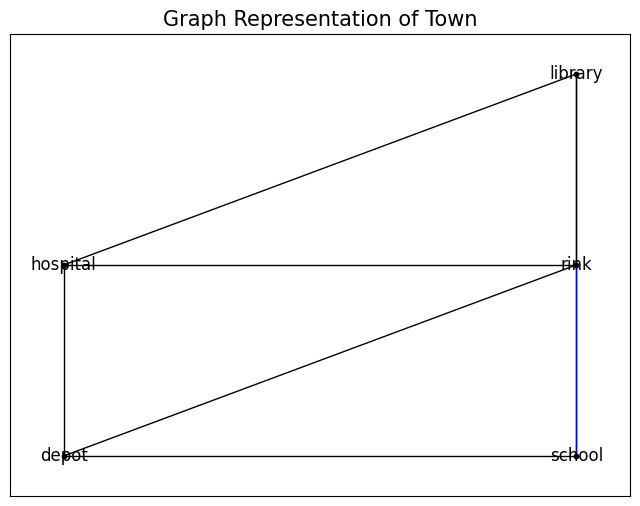

In [122]:
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos=node_positions, edge_color=edge_colors, node_size=10, node_color='black', with_labels=True)
plt.title('Graph Representation of Town', size=15)
plt.show()

### Part 2: Solving the Chinese Postman Problem

#### Step 1: Determine number of vertices with odd degree

In [123]:
odd_degree_nodes = [v for v,d in G.degree() if d%2 == 1]
print("number of nodes of odd degree:" , len(odd_degree_nodes))
print(odd_degree_nodes)

number of nodes of odd degree: 4
['depot', 'school', 'hospital', 'library']


#### Step 2: Find the minimum distance pairs between odd degree vertices.

This is the hardest part of the problem, broken down into five stages:

1. Compute all possible pairs of odd degree nodes.
2. Compute the shortest path between each node pair calculated in (1).
3. Create a complete graph connecting every node pair in (1). with shortest path distance attributes calculated in (2).
4. Compute a minimum weight matching of the graph calculated in (3).
(This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).
5. Augment the original graph with the shortest paths between the node pairs calculated in (5).


##### 2.1 - all possible combinations of odd degree nodes

In [124]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(odd_degree_nodes, 2))

print(odd_node_pairs)
print(len(odd_node_pairs))

[('depot', 'school'), ('depot', 'hospital'), ('depot', 'library'), ('school', 'hospital'), ('school', 'library'), ('hospital', 'library')]
6


##### 2.2 - Shortest path between each node pair

We can utilize networkx's shortest path algorithm, which implements Dijkstra’s algorithm.

In [125]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances
# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(G, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])


{('depot', 'school'): 1.0,
 ('depot', 'hospital'): 1.0,
 ('depot', 'library'): 2.41,
 ('school', 'hospital'): 2.0,
 ('school', 'library'): 2.0,
 ('hospital', 'library'): 1.41}

##### 2.3 Create Complete Graph

Create a complete graph with the nodes of odd degree.

Note: create_complete_graph is defined to calculate it. The flip_weights parameter is used to transform the distance to the weight attribute where smaller numbers reflect large distances and high numbers reflect short distances. This sounds a little counter intuitive, but is necessary for Step 2.4 where you calculate the minimum weight matching on the complete graph.

Ideally you’d calculate the minimum weight matching directly, but NetworkX only implements a max_weight_matching function which maximizes, rather than minimizes edge weight. We hack this a bit by negating (multiplying by -1) the distance attribute to get weight. This ensures that order and scale by distance are preserved, but reversed.



In [126]:
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters: 
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], **{'distance': v, 'weight': wt_i})  
    return g
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))


Number of nodes: 4
Number of edges: 6


Visualize complete graph of odd-degree nodes

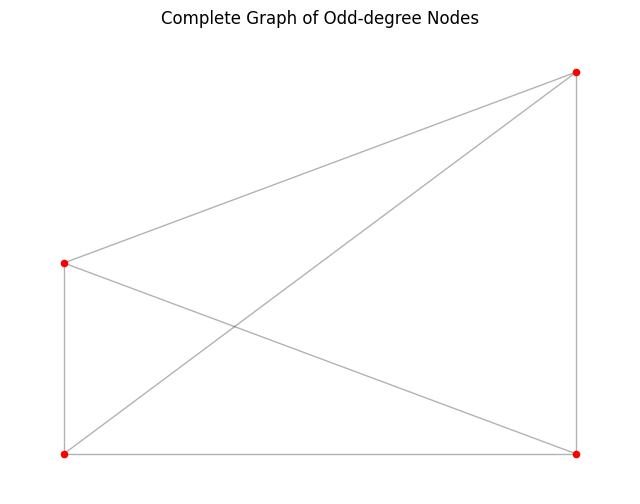

In [127]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.3)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()


##### 2.4: Compute Minimum Weight Matching

Extremely complicated algorithm, but luckily implemented in NetworkX package. Maximize the weights (which based on previous manipulations is minimizing distance) in a [matching](https://en.wikipedia.org/wiki/Matching_(graph_theory)).

Runs in $O(n^3)$ time

In [128]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching)))

print(odd_matching)

Number of edges in matching: 2
{('hospital', 'library'), ('depot', 'school')}


Plot the mininum weight matching on the complete graph

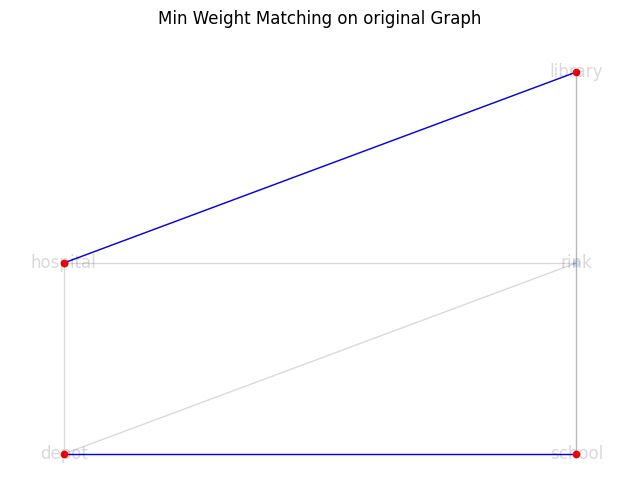

In [129]:
plt.figure(figsize=(8, 6))

# Plot the complete graph of odd-degree nodes
nx.draw_networkx(G, pos=node_positions, node_size=20, alpha=0.15, with_labels=True)

# Create a new graph to overlay on g_odd_complete with just the edges from the min weight matching
g_odd_complete_min_edges = nx.Graph(odd_matching)
nx.draw(g_odd_complete_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on original Graph')
plt.show()


##### 2.5 Augment the original graph

Add the edges to the original graph to make each vertice even degree, making it possible to find an Eulerian tour.

In [138]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """
    
    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0], 
                           pair[1], 
                           **{'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]), 'original': False}
                          )
    return graph_aug

G_aug = add_augmenting_path_to_graph(G, odd_matching)
print(G_aug) # added two extra edges
print(G)

MultiGraph with 5 nodes and 10 edges
Graph with 5 nodes and 8 edges


#### Step 3: Compute Eulerian Circuit

In [131]:
def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))
    
    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    
        if edge_data[0]['original'] == True:
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]] # dictionary of attributes
            euler_circuit.append((edge[0], edge[1], edge_att)) 
        else:
            # find the shortest path in the original graph
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))
            
            print('Filling in edges for augmented edge: {}'.format(edge))
            print('Augmenting path: {}'.format(' => '.join(aug_path)))
            print('Augmenting path pairs: {}\n'.format(aug_path_pairs))
            
            # If `edge` does not exist in original graph, find the shortest path between its nodes and 
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))
                                      
    return euler_circuit



In [135]:
euler_circut = create_eulerian_circuit(G_aug, G, 'depot')
for i, edge in enumerate(euler_circut):
    print(i, edge)

0 ('depot', 'hospital', {'distance': 1.0, 'color': 'black', 'original': True})
1 ('hospital', 'library', {'distance': 1.41, 'color': 'black', 'original': True})
2 ('library', 'hospital', {'distance': 1.41, 'color': 'black', 'original': True})
3 ('hospital', 'rink', {'distance': 1.0, 'color': 'black', 'original': True})
4 ('rink', 'library', {'distance': 1.0, 'color': 'black', 'original': True})
5 ('library', 'school', {'distance': 2.0, 'color': 'blue', 'original': True})
6 ('school', 'rink', {'distance': 1.0, 'color': 'black', 'original': True})
7 ('rink', 'depot', {'distance': 1.41, 'color': 'black', 'original': True})
8 ('depot', 'school', {'distance': 1.0, 'color': 'black', 'original': True})
9 ('school', 'depot', {'distance': 1.0, 'color': 'black', 'original': True})
